# Long Short-Term Memory (LSTM)
- 4 times more parameters than the simple RNN
- Mitigates vanishing gradient problem through gating
- Used for a long time with a lot of success, still SOTA in many applications
- Popular variant: Gated Recurrent Units (GRU)

**Gating Mechanism**
* Prominent in neural network algorithms, e.g. attention, LSTM, short cut connections.
* A gating function determines if information is propagated or ommited

## **Definition**

|||
|-------------|---------------------------------------------------------------------|
|hidden state | $\mathbf{h}_t \leftarrow \mathbf{o}_t \circ \sigma_h(\mathbf{c}_t)$ |
|cell state   | $\mathbf{c}_t \leftarrow \mathbf{f}_t \circ \mathbf{c}_{t-1} + \mathbf{i}_t \circ \mathbf{j}_t $ |
|output gate  | $\mathbf{o}_t \leftarrow \sigma_o(W_o \cdot \mathbf{x}_t + U_o \cdot \mathbf{h}_{t-1} + \mathbf{b}_o)$ |
|forget gate  | $\mathbf{f}_t \leftarrow \sigma_f(W_f \cdot \mathbf{x}_t + U_f \cdot \mathbf{h}_{t-1} + \mathbf{b}_f)$ |
|input gate   | $\mathbf{i}_t \leftarrow \sigma_i(W_i \cdot \mathbf{x}_t + U_i \cdot \mathbf{h}_{t-1} + \mathbf{b}_i)$|
|modulation gate| $\mathbf{j}_t \leftarrow \sigma_j(W_j \cdot \mathbf{x}_t + U_j \cdot \mathbf{h}_{t-1} + \mathbf{b}_j)$ |

- $W \in \mathbb{R}^{m \times d}$ weight matrices for input vector $\mathbf{x}_t$
- $U \in \mathbb{R}^{m \times m}$ weight matrices for hidden state vector $\mathbf{h}_{t-1}$
- activation functions $\sigma_h$ and $\sigma_j$ are usually $tanh$
- activation functions $\sigma_f$, $\sigma_i$, and $\sigma_o$ are usually $sigmoid$
- element-wise multiplication is $\circ$
    * important for gating (all values between usually between -1 and 1 (tanh) or 0 and 1 (sigmoid)
- cell state $\mathbf{c}$ : stores contextual and longer term information
- hidden state $\mathbf{h}$ : stores immediately necessary information and **is given to next layer**
![lstm_sideways.svg](attachment:lstm_sideways.svg)


### Comparison between fully connected, RNN, and LSTM:

![image.png](attachment:image.png)

# More Techniques

### Bidirectional RNNs

instead of only reading the time series left to right, also read it backwards.

- 2 RNN (LSTM) layer at the same abstraction, one reads forward, the other backwards
- output of both get concatenated, summed up, or selected via attention module
- backwards layer alone usually shows worse performance, but combined information from before and after can be utilized
- not applicable to online learning (new time step would require to do complete backward layer pass)
- also complicated for truncated backprop

![image.png](attachment:image.png)

<!-- ### Preprocess signal
is the addition of 1-D convolution layers to the model. They prepare the signal for following RNN layers. *Careful*: the kernel size of the convolution layers should be choosen carefully. -->

### Stacking LSTM layers
can be done to achieve deeper abstractions, but is computationally demanding. 

### Gradient Clipping
prevents exploding gradients due to bad initial weights, or outlier input.
Abnormally big gradients cannot get larger than specific value g:
$ dW = min(dW, g) $, which helps to smoothen out *bad* weight updates.

The clipping value $g$ is chosen by looking at the average gradients, often it is in the range from 1 to 10.


# Application: How Much Did it Rain? 2
https://www.kaggle.com/c/how-much-did-it-rain-ii/data

![image.png](attachment:image.png)

Input: polarimetric radar values

Target: the hourly rain gauge total

In [1]:
import os
# windows:
if os.name == 'nt':
    !python -m wget https://sid.erda.dk/share_redirect/DCadcaIwQV
# linux:
else:
    !wget https://sid.erda.dk/share_redirect/DCadcaIwQV

--2020-05-28 23:59:19--  https://sid.erda.dk/share_redirect/DCadcaIwQV
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225182067 (215M)
Saving to: ‘DCadcaIwQV’

DCadcaIwQV          100%[===================>] 214.75M  23.9MB/s    in 10s     

2020-05-28 23:59:29 (21.3 MB/s) - ‘DCadcaIwQV’ saved [225182067/225182067]



In [2]:
!unzip DCadcaIwQV

Archive:  DCadcaIwQV
  inflating: data.csv                


In [0]:
# linear algebra
import numpy as np 
# data processing
import pandas as pd 

DATA_DIR = "."

## 1. Import training data and extract ids

In [0]:
# load dataset (only 300000 entries)
data = pd.read_csv(f'{DATA_DIR}/data.csv', nrows=300000)
# get all ids
raw_ids_all = data["Id"]
# identify unique ids (one id belongs to a single time series)
raw_ids = raw_ids_all.unique()


In [5]:
# let's look at the data
data

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,26624,5,1.0,12.5,6.5,8.5,14.5,12.5,8.5,10.5,18.0,0.555000,0.548333,0.885000,0.998333,-1.1250,-3.5625,-0.9375,0.2500,9.399994,NaN,NaN,9.759995,0.254
299996,26624,10,1.0,1.5,1.5,7.0,13.5,6.5,6.5,9.0,13.5,0.875000,0.535000,0.875000,0.998333,-1.1875,-2.8125,-0.7500,0.6250,NaN,NaN,NaN,-2.110001,0.254
299997,26624,14,1.0,8.5,2.5,6.5,24.5,9.5,6.0,9.5,24.5,0.991667,0.655000,0.958333,1.001667,-0.3125,-3.1250,-0.3125,6.8750,NaN,NaN,NaN,-3.169998,0.254
299998,26624,19,1.0,7.0,-0.5,7.0,12.0,7.0,6.5,9.0,14.0,1.001667,0.935000,0.998333,1.005000,0.0000,-0.8125,0.1250,0.6875,NaN,NaN,NaN,NaN,0.254


In [6]:
# take a look at a single series
pd.set_option('display.max_columns', 24)
data[raw_ids[44]==data["Id"]]

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
469,45,1,12.0,18.5,15.0,18.5,24.5,18.5,16.0,21.0,24.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
470,45,6,12.0,17.0,13.5,17.0,25.0,17.0,17.0,20.5,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
471,45,11,12.0,15.5,12.5,18.5,25.0,22.5,18.5,23.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
472,45,16,12.0,22.0,19.0,23.5,29.0,23.5,21.0,26.5,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
473,45,21,12.0,22.5,17.5,23.0,29.5,31.0,19.0,26.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
474,45,26,12.0,25.5,20.0,24.0,27.5,25.5,22.5,25.0,27.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
475,45,31,12.0,26.0,20.5,26.0,30.0,30.0,23.5,27.5,33.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
476,45,37,12.0,20.5,23.0,26.5,32.0,25.5,26.5,29.5,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
477,45,42,12.0,30.5,24.5,28.0,32.0,30.5,27.5,30.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762
478,45,47,12.0,22.5,20.0,24.0,30.0,24.0,21.5,24.0,31.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.762


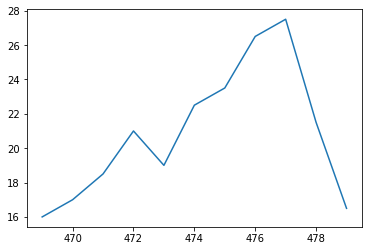

In [7]:
data[raw_ids[44]==data["Id"]]["RefComposite_5x5_10th"].plot()

**POLL HERE** 

In [8]:
data.shape

(300000, 24)

In [9]:
data.dtypes

Id                         int64
minutes_past               int64
radardist_km             float64
Ref                      float64
Ref_5x5_10th             float64
Ref_5x5_50th             float64
Ref_5x5_90th             float64
RefComposite             float64
RefComposite_5x5_10th    float64
RefComposite_5x5_50th    float64
RefComposite_5x5_90th    float64
RhoHV                    float64
RhoHV_5x5_10th           float64
RhoHV_5x5_50th           float64
RhoHV_5x5_90th           float64
Zdr                      float64
Zdr_5x5_10th             float64
Zdr_5x5_50th             float64
Zdr_5x5_90th             float64
Kdp                      float64
Kdp_5x5_10th             float64
Kdp_5x5_50th             float64
Kdp_5x5_90th             float64
Expected                 float64
dtype: object

In [0]:
# convert to float32 since tf usually expects these
for column in data.columns:
    data[column] = data[column].astype(np.float32)
data['Id'] = data['Id'].astype(np.int32)

## 2. Missing Data

In [0]:
# Remove ids with only NaNs in relevant columns (not the ones in nan_except) over all time steps
nan_except = ["Id", "minutes_past", "radardist_km", "Expected"]
# indicator where at least on entry per row is not  NaN
at_least_one = ~np.isnan(data.drop(nan_except, axis=1)).all(1)
no_nan_data = data[at_least_one]
# get all unique Ids that have at least one time step with valid observations
raw_ids_tmp = no_nan_data["Id"].unique()
# check each Id in original data if it is one of the valid Ids and select it
cleaned_data = data[np.isin(raw_ids_all, raw_ids_tmp)]

In [0]:
# fill missing values with 0 (might not be the best idea)
cleaned_data = cleaned_data.fillna(0.0)

In [13]:
cleaned_data

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,RhoHV,RhoHV_5x5_10th,RhoHV_5x5_50th,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
6,2,1.0,2.0,9.0,5.0,7.5,10.5,15.0,10.5,16.5,23.5,0.998333,0.998333,0.998333,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016001
7,2,6.0,2.0,26.5,22.5,25.5,31.5,26.5,26.5,28.5,32.0,1.001667,0.981667,0.998333,1.005000,0.0625,-0.1875,0.2500,0.6875,0.000000,0.000000,0.000000,1.409988,1.016001
8,2,11.0,2.0,21.5,15.5,20.5,25.0,26.5,23.5,25.0,27.0,1.001667,0.995000,0.998333,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,0.000000,-0.350006,1.759995,1.016001
9,2,16.0,2.0,18.0,14.0,17.5,21.0,20.5,18.0,20.5,23.0,0.995000,0.995000,0.998333,1.001667,0.2500,0.1250,0.3750,0.6875,0.349991,-1.059998,0.000000,1.059998,1.016001
10,2,21.0,2.0,24.5,16.5,21.0,24.5,24.5,21.0,24.0,28.0,0.998333,0.995000,0.998333,0.998333,0.2500,0.0625,0.1875,0.5625,-0.350006,-1.059998,-0.350006,1.759995,1.016001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,26624,5.0,1.0,12.5,6.5,8.5,14.5,12.5,8.5,10.5,18.0,0.555000,0.548333,0.885000,0.998333,-1.1250,-3.5625,-0.9375,0.2500,9.399994,0.000000,0.000000,9.759995,0.254000
299996,26624,10.0,1.0,1.5,1.5,7.0,13.5,6.5,6.5,9.0,13.5,0.875000,0.535000,0.875000,0.998333,-1.1875,-2.8125,-0.7500,0.6250,0.000000,0.000000,0.000000,-2.110001,0.254000
299997,26624,14.0,1.0,8.5,2.5,6.5,24.5,9.5,6.0,9.5,24.5,0.991667,0.655000,0.958333,1.001667,-0.3125,-3.1250,-0.3125,6.8750,0.000000,0.000000,0.000000,-3.169998,0.254000
299998,26624,19.0,1.0,7.0,-0.5,7.0,12.0,7.0,6.5,9.0,14.0,1.001667,0.935000,0.998333,1.005000,0.0000,-0.8125,0.1250,0.6875,0.000000,0.000000,0.000000,0.000000,0.254000


In [14]:
print(f"{len(cleaned_data)/len(data)*100}% time steps remaining")

73.75466666666667% time steps remaining


## 3. Define and exclude outliers

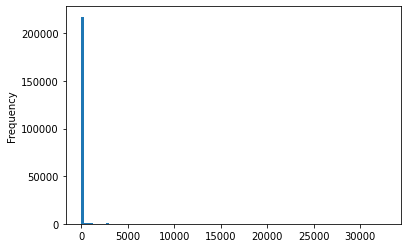

In [15]:
cleaned_data["Expected"].plot.hist(bins=100)

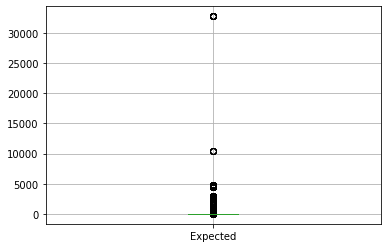

In [16]:
cleaned_data.boxplot(column="Expected")

In [17]:
# This would be ~33m per square meter in an hour! This is highly suspicious!
cleaned_data["Expected"].describe()

count    221264.000000
mean         38.525028
std         381.507141
min           0.010000
25%           0.254000
50%           1.016001
75%           3.556002
max       32740.617188
Name: Expected, dtype: float64

**Standard deviation method**
* good for Gaussian distributed data
* considered thresholds ($t$) are:
    * ~68% of data is covered by 1 $\times$ standard deviation
    * ~95% of data is covered by 2 $\times$ standard deviation
    * ~99% of data is covered by 3 $\times$ standard deviation
* keep: $ -std(x) * t < x < std(x) * t $

**Interquartile range method**
* also works for non-Gaussian data
* 25% and 75% quantiles define box of boxplot
* steps:
    1. calculate 25% ($q_{25}$) and 75% ($q_{75}$ quantiles of data (x)
    2. interquartile range  is defined as: $iqr = q_{75} - q_{25}$
    3. cutoff value: $t * iqr$
        * defines the whiskers in a box-plot
        * $t$ is usually set to 1.5 and sometimes 3
        * why 1.5? it roughly defines between 2 and 3 times standard deviation
![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/640px-Boxplot_vs_PDF.svg.png?1589793853423)

**Learned outlier detection**:
* outlier problem can be seen as one-class classification
* exemplary methods: one-class SVM, Local Outlier Factor, Local Outlier Density Factor, IsolationForest
    


In [0]:
# let us remove outliers with the interquartile range method)
q25, q75 = np.quantile(cleaned_data, .25), np.quantile(cleaned_data, .75)
inter_quantile_range = q75 - q25

In [0]:
# calculate the outlier cutoff
cut_off = inter_quantile_range * 1.5
lower = q25 - cut_off
upper = q75 + cut_off

In [20]:
print(lower, upper)

-24.0 40.0


In [0]:
cleaned_data_gp = cleaned_data.groupby('Id')
df = pd.DataFrame(cleaned_data_gp['Expected'].mean()) # mean, or any value
meaningful_ids = np.array(df[(df['Expected'] < upper) & (df['Expected'] > lower)].index) # all values above threshold are excluded

In [0]:
final_data = cleaned_data[np.isin(cleaned_data.Id, meaningful_ids)]

In [23]:
# mean is much closer to the median value
final_data["Expected"].describe()

count    213208.000000
mean          2.792479
std           4.709725
min           0.010000
25%           0.254000
50%           1.016001
75%           3.048002
max          39.624023
Name: Expected, dtype: float64

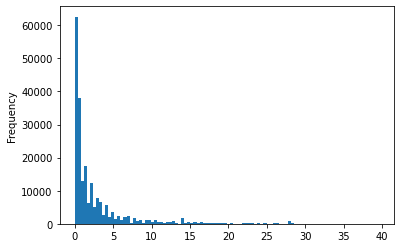

In [24]:
final_data["Expected"].plot.hist(bins=100)

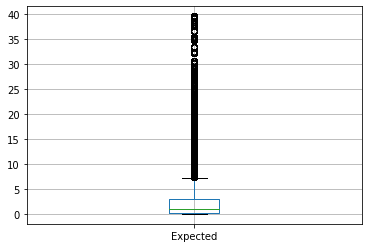

In [25]:
final_data.boxplot(column="Expected")

In [26]:
print(f"{len(final_data)/len(data)*100}% time steps remaining")

71.06933333333333% time steps remaining


## 4. Final Dataset

In [0]:
# group by id to get all time steps for a single id
data_pd_gp = final_data.groupby("Id")
data_size = len(data_pd_gp)

In [28]:
# how many time steps at most?
data_max_steps = data_pd_gp.count().max(0)
data_max_steps

minutes_past             19
radardist_km             19
Ref                      19
Ref_5x5_10th             19
Ref_5x5_50th             19
Ref_5x5_90th             19
RefComposite             19
RefComposite_5x5_10th    19
RefComposite_5x5_50th    19
RefComposite_5x5_90th    19
RhoHV                    19
RhoHV_5x5_10th           19
RhoHV_5x5_50th           19
RhoHV_5x5_90th           19
Zdr                      19
Zdr_5x5_10th             19
Zdr_5x5_50th             19
Zdr_5x5_90th             19
Kdp                      19
Kdp_5x5_10th             19
Kdp_5x5_50th             19
Kdp_5x5_90th             19
Expected                 19
dtype: int64

In [29]:
# how many time steps at least?
data_min_steps = data_pd_gp.count().min(0)
data_min_steps

minutes_past             5
radardist_km             5
Ref                      5
Ref_5x5_10th             5
Ref_5x5_50th             5
Ref_5x5_90th             5
RefComposite             5
RefComposite_5x5_10th    5
RefComposite_5x5_50th    5
RefComposite_5x5_90th    5
RhoHV                    5
RhoHV_5x5_10th           5
RhoHV_5x5_50th           5
RhoHV_5x5_90th           5
Zdr                      5
Zdr_5x5_10th             5
Zdr_5x5_50th             5
Zdr_5x5_90th             5
Kdp                      5
Kdp_5x5_10th             5
Kdp_5x5_50th             5
Kdp_5x5_90th             5
Expected                 5
dtype: int64

In [0]:
# create a padding function to have same input length for all time series
def pad_series(X, target_len):
    seq_len = X.shape[0] # current length
    pad_size = target_len - seq_len # how much do we need to pad
    if (pad_size > 0):
        X = np.pad(X, ((0, pad_size), (0, 0)), 'constant', constant_values=0.)
    return X#, seq_len

In [31]:
series_length = np.max(data_max_steps)
dims = len(data_max_steps) - 1 # 22, excluded target entry "Expected"

X = np.empty((data_size, series_length, dims))
# seq_lengths = np.zeros(data_size)
y = np.zeros(data_size)

i = 0
for _, group in data_pd_gp:
    group_array = np.array(group)
    x = pad_series(group_array[:, 1:dims+1], target_len=series_length) # exclude id and "Expected"
    y_ = group_array[0, dims+1] # expected value [23] at time 0 (could be any time)
    X[i, :, :] = x
#     seq_lengths[i] = seq_length
    y[i]= y_
    i += 1

X.shape, y.shape

# note: alternatively we could also pad every batch individually when it is created

((17467, 19, 22), (17467,))

In [0]:
# separate into training and validation
val_ratio = 0.8
split = int(len(X)*val_ratio)

# random seed
random = np.random.RandomState(42)
# create a random shuffle for training/validation

idx = np.arange(len(X))
random.shuffle(idx)
idx_train = idx[:split]
idx_test = idx[split:]

X_train = X[idx_train]
y_train = y[idx_train]

X_val = X[idx_test]
y_val = y[idx_test]

In [0]:
# apply scaling (careful, we already removed outliers)

from sklearn.preprocessing import RobustScaler
X_train_shape = X_train.shape
X_val_shape = X_val.shape
# need to flatten time axis
flat_X_train = X_train.reshape(-1, X_train_shape[-1])
flat_X_val = X_val.reshape(-1, X_val_shape[-1])
scaler = RobustScaler().fit(flat_X_train)
# transform and reshape to original shape
X_train = scaler.transform(flat_X_train).reshape(X_train_shape)
X_val = scaler.transform(flat_X_val).reshape(X_val_shape)

## 5. Create and train a recurrent Model

#### Define Model

In [0]:
# import some layer
from tensorflow.keras.layers import SimpleRNN, Input, Dense, LSTM, GRU, AveragePooling1D, TimeDistributed, Bidirectional, Conv1D, Flatten, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import activations, initializers

In [0]:
def get_model_dense(shape):
    # problem here: if test set has more time steps, we need to ommit them
    inp = Input(shape)
    x = Flatten()(inp)
    x = Dense(64, "tanh")(x) # only able to process fixed amount of time steps
    x = Dense(1)(x)

    model = Model(inp, x)
    return model

# LSTM model
def get_model_rnn(shape):
    inp = Input(shape)
    x = LSTM(64, return_sequences=False)(inp)
    x = Dense(1)(x)

    model = Model(inp, x)
    return model

# Bidirectional LSTM
def get_model_rnn_bidi(shape):
    inp = Input(shape)
    x = Bidirectional(LSTM(64, return_sequences=False))(inp)
    x = Dense(1)(x)

    model = Model(inp, x)
    return model

# Stack LSTM
def get_model_rnn_stack(shape):
    inp = Input(shape)
    x = LSTM(64, return_sequences=True)(inp)
    x = LSTM(64, return_sequences=False)(x)
    x = Dense(1)(x)

    model = Model(inp, x)
    return model

# Conv1d LSTM
def get_model_rnn_conv(shape):
    inp = Input(shape)
    x = Conv1D(32, kernel_size=3, strides=1)(inp)
    x = LSTM(64, return_sequences=False)(x)
    x = Dense(1)(x)

    model = Model(inp, x)
    return model

# LSTM model that will be trained with clipped gradient
def get_model_rnn_clipped(shape):
    inp = Input(shape)
    x = LSTM(64, return_sequences=False)(inp)
    x = Dense(1)(x)

    model = Model(inp, x)
    return model

# Can provide stats of each one if you want

In [36]:
model_dense = get_model_dense((series_length, dims))
model_dense.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 22)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 418)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                26816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 26,881
Trainable params: 26,881
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_rnn = get_model_rnn((series_length, dims))
model_rnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 19, 22)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                22272     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 22,337
Trainable params: 22,337
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_rnn_bidi = get_model_rnn_bidi((series_length, dims))
model_rnn_bidi.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 19, 22)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               44544     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 44,673
Trainable params: 44,673
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_rnn_stack = get_model_rnn_stack((series_length, dims))
model_rnn_stack.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 19, 22)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 19, 64)            22272     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 55,361
Trainable params: 55,361
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_rnn_conv = get_model_rnn_conv((series_length, dims))
model_rnn_conv.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 19, 22)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 17, 32)            2144      
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 27,041
Trainable params: 27,041
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_rnn_clipped = get_model_rnn_conv((series_length, dims))

In [0]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
sgd_clipped = SGD(lr=0.01, momentum=0.9, nesterov=True, clipvalue = 1)
model_dense.compile(sgd, loss='mae')
model_rnn.compile(sgd, loss='mae')
model_rnn_stack.compile(sgd, loss='mae')
model_rnn_bidi.compile(sgd, loss='mae')
model_rnn_conv.compile(sgd, loss='mae')
model_rnn_clipped.compile(sgd_clipped, loss='mae')

In [59]:
model_dense.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1)

Epoch 1/5
437/437 [==============================] - 1s 1ms/step - loss: 2.1051
Epoch 2/5
437/437 [==============================] - 1s 1ms/step - loss: 2.0770
Epoch 3/5
437/437 [==============================] - 1s 1ms/step - loss: 2.0542
Epoch 4/5
437/437 [==============================] - 1s 1ms/step - loss: 2.0298
Epoch 5/5
437/437 [==============================] - 1s 1ms/step - loss: 2.0073


In [60]:
model_rnn.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1)

Epoch 1/5
437/437 [==============================] - 5s 11ms/step - loss: 2.0726
Epoch 2/5
437/437 [==============================] - 7s 15ms/step - loss: 2.0527
Epoch 3/5
437/437 [==============================] - 4s 10ms/step - loss: 2.0343
Epoch 4/5
437/437 [==============================] - 4s 10ms/step - loss: 2.0248
Epoch 5/5
437/437 [==============================] - 4s 10ms/step - loss: 2.0120


In [61]:
model_rnn_bidi.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1)

Epoch 1/5
437/437 [==============================] - 7s 16ms/step - loss: 2.0667
Epoch 2/5
437/437 [==============================] - 7s 16ms/step - loss: 2.0453
Epoch 3/5
437/437 [==============================] - 7s 16ms/step - loss: 2.0187
Epoch 4/5
437/437 [==============================] - 7s 16ms/step - loss: 1.9971
Epoch 5/5
437/437 [==============================] - 7s 16ms/step - loss: 1.9943


In [62]:
model_rnn_stack.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1) 

Epoch 1/5
437/437 [==============================] - 9s 21ms/step - loss: 2.0784
Epoch 2/5
437/437 [==============================] - 9s 21ms/step - loss: 2.0574
Epoch 3/5
437/437 [==============================] - 9s 21ms/step - loss: 2.0379
Epoch 4/5
437/437 [==============================] - 9s 21ms/step - loss: 2.0253
Epoch 5/5
437/437 [==============================] - 9s 21ms/step - loss: 2.0232


In [63]:
model_rnn_conv.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1)

Epoch 1/5
437/437 [==============================] - 5s 12ms/step - loss: 2.0888
Epoch 2/5
437/437 [==============================] - 5s 11ms/step - loss: 2.0823
Epoch 3/5
437/437 [==============================] - 5s 11ms/step - loss: 2.0567
Epoch 4/5
437/437 [==============================] - 5s 12ms/step - loss: 2.0431
Epoch 5/5
437/437 [==============================] - 5s 11ms/step - loss: 2.0388


In [64]:
model_rnn_clipped.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1)

Epoch 1/5
437/437 [==============================] - 5s 12ms/step - loss: 2.0810
Epoch 2/5
437/437 [==============================] - 5s 11ms/step - loss: 2.0750
Epoch 3/5
437/437 [==============================] - 5s 11ms/step - loss: 2.0693
Epoch 4/5
437/437 [==============================] - 5s 12ms/step - loss: 2.0527
Epoch 5/5
437/437 [==============================] - 5s 11ms/step - loss: 2.0239


In [71]:
val_preds_dense = model_dense.predict(X_val, batch_size=32, verbose=1)
val_preds_rnn = model_rnn.predict(X_val, batch_size=32, verbose=1)
val_preds_rnn_bidi = model_rnn_bidi.predict(X_val, batch_size=32, verbose=1)
val_preds_rnn_stack = model_rnn_stack.predict(X_val, batch_size=32, verbose=1)
val_preds_rnn_conv = model_rnn_conv.predict(X_val, batch_size=32, verbose=1)
val_preds_rnn_clipped = model_rnn_clipped.predict(X_val, batch_size=32, verbose=1)

110/110 [==============================] - 0s 4ms/step


In [0]:
absolute_error_dense = abs(y_val-val_preds_dense[:, 0])
absolute_error_rnn = abs(y_val-val_preds_rnn[:, 0])
absolute_error_rnn_bidi = abs(y_val-val_preds_rnn_bidi[:, 0])
absolute_error_rnn_stack = abs(y_val-val_preds_rnn_stack[:, 0])
absolute_error_rnn_conv = abs(y_val-val_preds_rnn_conv[:, 0])
absolute_error_rnn_clipped = abs(y_val-val_preds_rnn_clipped[:, 0])

In [0]:
errors = pd.DataFrame(np.stack((absolute_error_dense, absolute_error_rnn, 
                                absolute_error_rnn_bidi, absolute_error_rnn_stack, 
                                absolute_error_rnn_conv, absolute_error_rnn_clipped), 1), 
                      columns=["dense", "rnn", "rnn bidi", "rnn stack", "rnn conv", "rnn clipped"])

In [74]:
errors.describe()

,dense,rnn,rnn bidi,rnn stack,rnn conv,rnn clipped
count,3494.000000,3494.000000,3494.000000,3494.000000,3494.000000,3494.000000
mean,2.218558,1.970323,1.955470,2.025149,2.032951,2.121872
std,3.950146,3.641677,3.582630,3.766535,3.853634,3.577072
min,0.000452,0.000407,0.000285,0.000344,0.000117,0.000492
25%,0.414624,0.214678,0.317151,0.373774,0.320270,0.304884
50%,0.974535,0.655499,0.711318,0.710446,0.678142,0.777964
75%,1.989411,1.963347,1.776480,1.811859,1.814374,2.306931
max,40.752519,37.765267,38.335264,37.875725,36.406474,37.334996


More things to try:
* more layers (stacked LSTM)
* padding per batch instead of complete dataset (should result in faster training)
* filtering the signal first via 1d convultion
* different optimizer